In [1]:
#import pandas as pd
#import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.pyplot import imread, imshow, subplots, show

#rom sklearn.metrics import RocCurveDisplay

In [2]:
# Load the subset from the file
data = np.load('Tomato_balanced.npz')
X_train_balanced = data['X_train_balanced']
y_train_balanced = data['y_train_balanced']

In [3]:
# Load the subset from the file
data = np.load('Tomato_test.npz')
X_test = data['X_test']
y_test = data['y_test']

In [4]:
class_labels = ['Early_blight','Healthy','Late_blight','Leaf_Miner',
                 'Magnesium_Deficiency','Nitrogen_Deficiency','Pottassium_Deficiency','Spotted_Wilt_Virus']

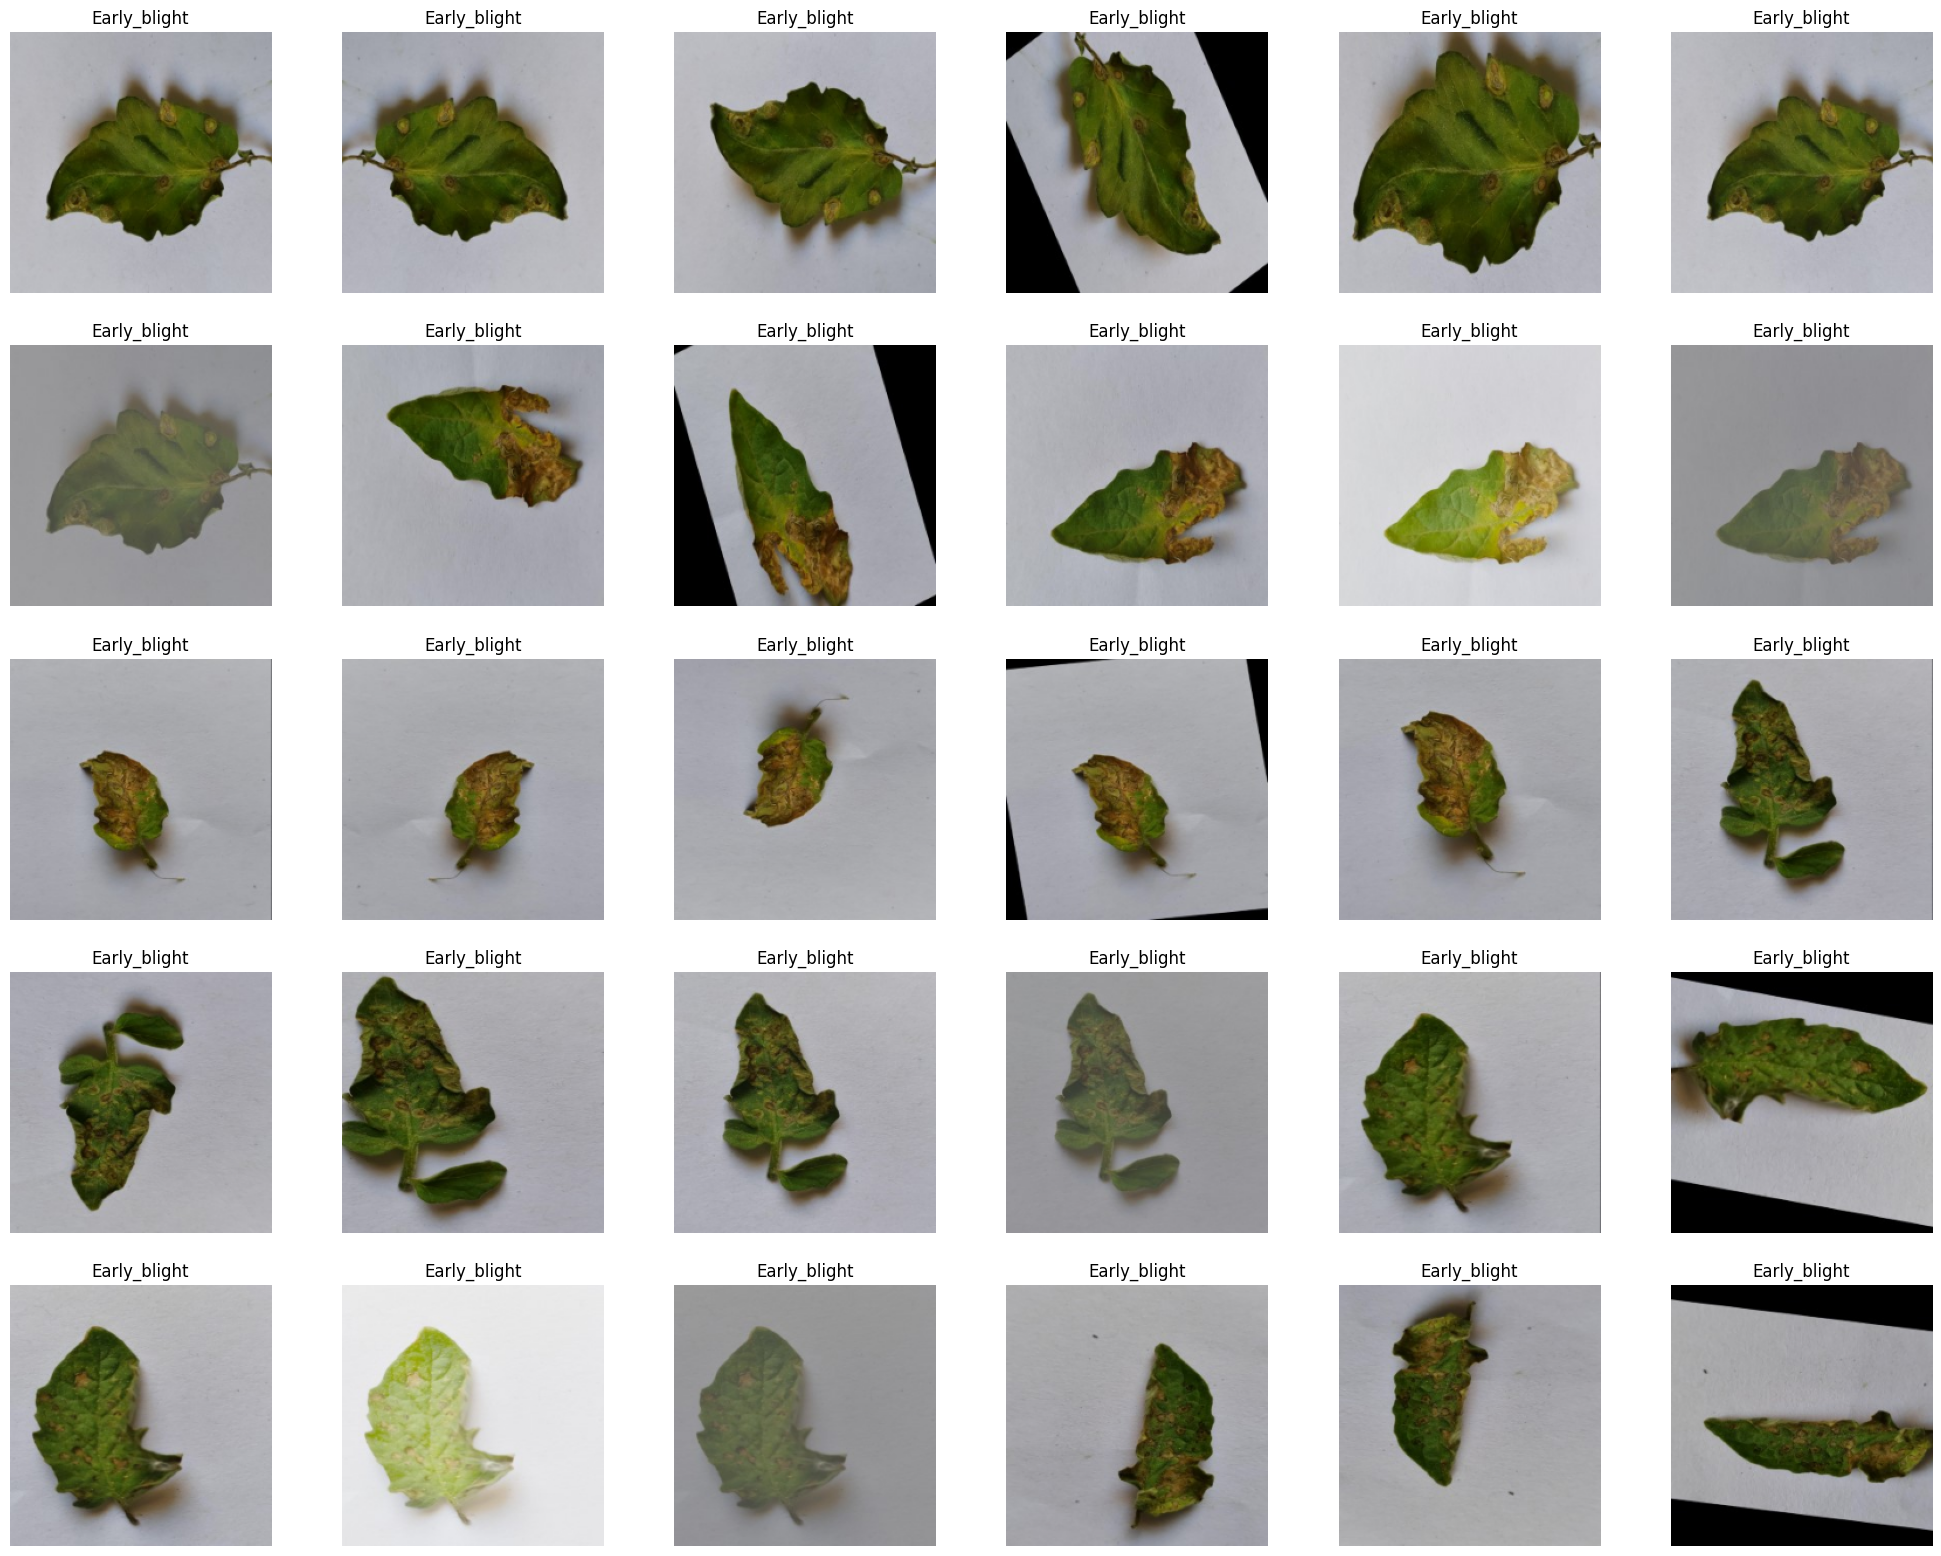

In [5]:
plt.figure(figsize=(25,40))
for i in range(30):
    plt.subplot(10,6,i+1)
    plt.imshow(X_train_balanced[i])
    plt.title(class_labels[y_train_balanced[i]])
    plt.axis("off")

In [6]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import ResNet50, ResNet101, ResNet152, MobileNet, VGG16
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Dropout, MaxPooling2D, Conv2D, Activation, Flatten,GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam

#from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2

In [7]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, kernel_size = (3,3), activation = 'relu', input_shape = (224,224,3)),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Conv2D(32, kernel_size = (3,3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Conv2D(64, kernel_size = (3,3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Conv2D(64, kernel_size = (3,3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Conv2D(128, kernel_size = (3,3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Conv2D(128, kernel_size = (3,3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Flatten(), 
    
    tf.keras.layers.Dense(256, activation='relu'),
    
    tf.keras.layers.Dense(8, activation='softmax'),
    
])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 222, 222, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 109, 109, 32)      9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 54, 54, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 52, 52, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 26, 26, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 24, 24, 64)        3

In [8]:

feature_extractor = Model(inputs=model.input, outputs=model.layers[-5].output)  # The last Conv2D layer before Flatten

feature_extractor.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_input (InputLayer)    [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 222, 222, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 109, 109, 32)      9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 54, 54, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 52, 52, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 26, 26, 64)        0     

In [9]:
from sklearn.svm import SVC
#from sklearn.utils.class_weight import compute_class_weight

#class_weights = compute_class_weight('balanced', classes=np.unique(y_train_balanced), y=y_train_balanced)
#class_weight_dict = dict(zip(np.unique(y_train_balanced), class_weights))

svm_cnn = SVC(kernel='poly', probability=True, random_state=42) # class_weight=class_weight_dict

In [10]:
import time
start = time.time()

print("Extracting features from training data...")
X_train_features = feature_extractor.predict(X_train_balanced)

# Flatten the features to 2D
num_samples = X_train_features.shape[0]  # Number of images
num_features = np.prod(X_train_features.shape[1:])  # Number of features (height * width * channels)
X_train_features_flat = X_train_features.reshape(num_samples, num_features)  # Reshape to (samples, features)

print("Fitting SVM...")
svm_cnn.fit(X_train_features_flat, y_train_balanced)  # Use the flattened features here

end = time.time()
total_time = end - start
print(f"Total time taken: {total_time} seconds")


Extracting features from training data...
Fitting SVM...
Total time taken: 31.871186017990112 seconds


In [11]:
print(f"Total time taken for fitting: {total_time:.2f} sec")

Total time taken for fitting: 31.87 sec


In [12]:
X_train_features_flat

array([[0.01917961, 0.        , 0.        , ..., 0.        , 0.02332285,
        0.        ],
       [0.02085494, 0.        , 0.        , ..., 0.        , 0.02395897,
        0.        ],
       [0.02524876, 0.        , 0.        , ..., 0.        , 0.02229569,
        0.        ],
       ...,
       [0.0144676 , 0.        , 0.        , ..., 0.        , 0.01107061,
        0.        ],
       [0.01960935, 0.        , 0.        , ..., 0.        , 0.02262652,
        0.        ],
       [0.01751954, 0.        , 0.        , ..., 0.        , 0.01622872,
        0.        ]], dtype=float32)

In [13]:
# Extract features for the test data
print("Extracting features from test data...")
X_test_features = feature_extractor.predict(X_test)


# Flatten the features to 2D
num_samples = X_test_features.shape[0]  # Number of images
num_features = np.prod(X_test_features.shape[1:])  # Number of features (height * width * channels)
X_test_features_flat = X_test_features.reshape(num_samples, num_features)  # Reshape to (samples, features)

Extracting features from test data...


In [14]:
# Print the shape of the features to check
print(f"X_train_features shape: {X_train_features_flat.shape}")
print(f"X_test_features shape: {X_test_features_flat.shape}")

X_train_features shape: (4252, 1152)
X_test_features shape: (461, 1152)


In [15]:
# Predict on the test set
y_pred = svm_cnn.predict(X_test_features_flat)
y_pred

array([7, 3, 4, 4, 7, 0, 0, 4, 3, 4, 3, 0, 4, 4, 3, 3, 3, 3, 2, 4, 3, 3,
       4, 3, 3, 0, 7, 4, 7, 3, 3, 4, 2, 7, 7, 7, 4, 4, 4, 4, 3, 3, 3, 2,
       3, 3, 3, 4, 3, 3, 3, 3, 3, 7, 7, 3, 3, 3, 3, 5, 3, 7, 7, 3, 3, 0,
       3, 3, 3, 3, 3, 3, 3, 2, 2, 3, 4, 4, 2, 2, 3, 4, 2, 2, 4, 7, 7, 2,
       7, 4, 4, 2, 2, 3, 2, 3, 2, 0, 2, 2, 2, 2, 2, 2, 5, 5, 2, 2, 2, 2,
       4, 4, 2, 2, 7, 2, 2, 2, 2, 1, 4, 4, 2, 7, 2, 4, 3, 3, 2, 3, 3, 2,
       2, 4, 2, 2, 4, 2, 2, 2, 2, 2, 2, 4, 2, 2, 2, 4, 4, 4, 7, 2, 3, 4,
       7, 7, 2, 4, 4, 4, 7, 4, 4, 2, 3, 3, 7, 3, 3, 0, 7, 3, 3, 3, 0, 3,
       3, 0, 0, 4, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 7, 3, 3, 3, 3, 3, 3,
       2, 3, 3, 3, 7, 3, 3, 3, 3, 3, 3, 4, 3, 3, 3, 3, 3, 4, 7, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 4, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 4, 3, 3, 3, 3, 3, 3, 3, 7, 3, 3, 2, 3, 3, 3, 3,
       3, 3, 3, 3, 0, 4, 3, 4, 4, 4, 7, 4, 3, 0, 5, 3, 4, 4, 3, 3, 3, 3,
       2, 4, 3, 4, 4, 3, 0, 4, 0, 4, 4, 4, 3, 4, 4,

In [16]:
y_test

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,

In [17]:
from sklearn.metrics import confusion_matrix, roc_curve, auc, accuracy_score, classification_report, RocCurveDisplay, recall_score, f1_score
from sklearn.metrics import precision_score

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
precision_per_class = precision_score(y_test, y_pred, average=None)
f1_per_class = f1_score(y_test, y_pred, average=None)

# Print metrics as percentages rounded to 2 decimal places
print(f"SVM Test Accuracy: {accuracy * 100:.2f}%")
print(f"Precision: {precision * 100:.2f}%")
print(f"Recall: {recall * 100:.2f}%")
print(f"F1 Score: {f1 * 100:.2f}%")

# Print precision and F1 score per class, rounded to 2 decimal places as percentages
print(f"Precision per Class: {[round(p * 100, 2) for p in precision_per_class]}%")
print(f"F1 Score per Class: {[round(f * 100, 2) for f in f1_per_class]}%")

SVM Test Accuracy: 50.33%
Precision: 46.43%
Recall: 50.33%
F1 Score: 46.18%
Precision per Class: [26.67, 0.0, 56.79, 52.47, 48.15, 72.22, 0.0, 40.43]%
F1 Score per Class: [12.31, 0.0, 53.18, 63.91, 56.52, 47.27, 0.0, 38.0]%


C:\Users\SwarnaliMollick\anaconda3\envs\tfgpu\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\SwarnaliMollick\anaconda3\envs\tfgpu\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [18]:
report = classification_report(y_test, y_pred)
    
print(report)

              precision    recall  f1-score   support

           0       0.27      0.08      0.12        50
           1       0.00      0.00      0.00        22
           2       0.57      0.50      0.53        92
           3       0.52      0.82      0.64       104
           4       0.48      0.68      0.57        95
           5       0.72      0.35      0.47        37
           6       0.00      0.00      0.00         8
           7       0.40      0.36      0.38        53

    accuracy                           0.50       461
   macro avg       0.37      0.35      0.34       461
weighted avg       0.46      0.50      0.46       461



C:\Users\SwarnaliMollick\anaconda3\envs\tfgpu\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\SwarnaliMollick\anaconda3\envs\tfgpu\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\SwarnaliMollick\anaconda3\envs\tfgpu\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitaliz

[[ 4  0  3 21 15  0  0  7]
 [ 1  0  0 16  0  1  0  4]
 [ 1  1 46 10 23  2  0  9]
 [ 4  0  4 85  5  0  0  6]
 [ 5  1  3 18 65  2  0  1]
 [ 0  0  8  0 16 13  0  0]
 [ 0  0  2  0  5  0  0  1]
 [ 0  1 15 12  6  0  0 19]]


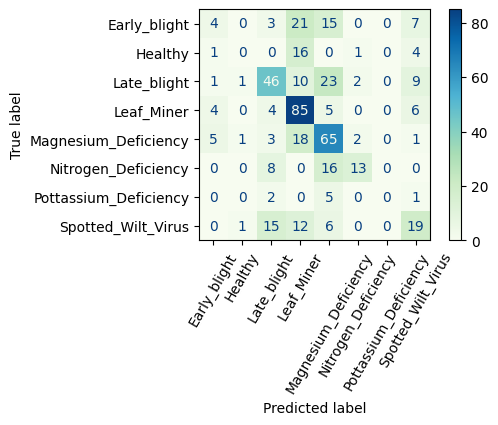

In [20]:
from sklearn.metrics import ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred)
print(cm)


display_cm = ConfusionMatrixDisplay(cm, display_labels=class_labels)
fig,ax = plt.subplots(figsize=(5,3))
display_cm.plot(cmap='GnBu', ax=ax, xticks_rotation=60)

In [21]:
from sklearn.metrics import roc_curve, auc
import sklearn

y_pred_prob = svm_cnn.predict_proba(X_test_features_flat)

# Calculate the ROC AUC score (multi-class)
sklearn.metrics.roc_auc_score(y_test, y_pred_prob, multi_class='ovr')

0.8380515730446612

In [22]:
from sklearn.metrics import cohen_kappa_score
cohen_kappa_score(y_test, y_pred)

0.38416081855993656

In [23]:
from sklearn.metrics import log_loss
log_loss(y_test, y_pred_prob)

1.3405277943852372

In [24]:
from tensorflow.keras.utils import to_categorical
y_test_cat = tf.keras.utils.to_categorical(y_test)
y_test_cat

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]], dtype=float32)

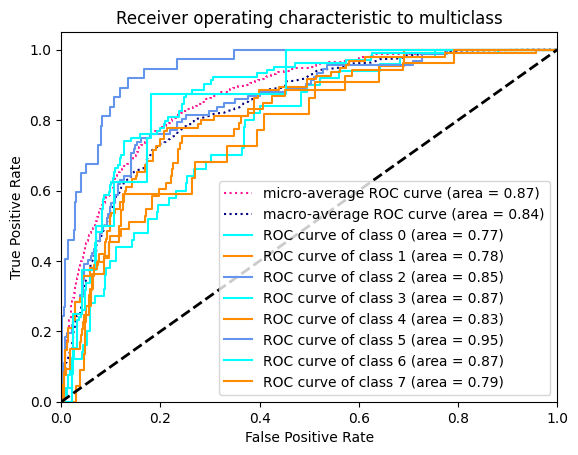

In [25]:
n_classes=8
 
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_cat[:, i], y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_cat.ravel(), y_pred_prob.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

lw=2

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
from itertools import cycle
# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])



##### Plot all ROC curves ######


plt.figure()
plt.plot(
    fpr["micro"],
    tpr["micro"],
    label="micro-average ROC curve (area = {0:0.2f})".format(roc_auc["micro"]),
    color="deeppink",
    linestyle="dotted",
    linewidth=1.5,
)

plt.plot(
    fpr["macro"],
    tpr["macro"],
    label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro"]),
    color="navy",
    linestyle="dotted",
    linewidth=1.5,
)

colors = cycle(["aqua", "darkorange", "cornflowerblue"])
for i, color in zip(range(n_classes), colors):
    plt.plot(
        fpr[i],
        tpr[i],
        color=color,
        lw=1.5,
        label="ROC curve of class {0} (area = {1:0.2f})".format(i, roc_auc[i]),
    )

plt.plot([0, 1], [0, 1], "k--", lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic to multiclass")
plt.legend(loc="lower right")
plt.show()

In [26]:
import pickle

with open('svm_cnn.pkl', 'wb') as model_file:
    pickle.dump(svm_cnn, model_file)

In [27]:
# Load the model from the file
with open('svm_cnn.pkl', 'rb') as model_file:
    svm_cnn = pickle.load(model_file)

In [28]:
# Save the subset to a file (you can use npz format or CSV for simplicity)
np.savez('CNN_SVM_test_Feature.npz', X_test_features_flat=X_test_features_flat, y_test=y_test)

In [33]:
# Load the subset from the file
data = np.load('CNN_SVM_test_Feature.npz')
X_test_features_flat = data['X_test_features_flat']
y_test = data['y_test']

In [34]:
X_test_features_flat.shape

(461, 1152)

In [37]:
# Predict on the test set
y_pred = svm_cnn.predict(X_test_features_flat)
y_pred

array([7, 3, 4, 4, 7, 0, 0, 4, 3, 4, 3, 0, 4, 4, 3, 3, 3, 3, 2, 4, 3, 3,
       4, 3, 3, 0, 7, 4, 7, 3, 3, 4, 2, 7, 7, 7, 4, 4, 4, 4, 3, 3, 3, 2,
       3, 3, 3, 4, 3, 3, 3, 3, 3, 7, 7, 3, 3, 3, 3, 5, 3, 7, 7, 3, 3, 0,
       3, 3, 3, 3, 3, 3, 3, 2, 2, 3, 4, 4, 2, 2, 3, 4, 2, 2, 4, 7, 7, 2,
       7, 4, 4, 2, 2, 3, 2, 3, 2, 0, 2, 2, 2, 2, 2, 2, 5, 5, 2, 2, 2, 2,
       4, 4, 2, 2, 7, 2, 2, 2, 2, 1, 4, 4, 2, 7, 2, 4, 3, 3, 2, 3, 3, 2,
       2, 4, 2, 2, 4, 2, 2, 2, 2, 2, 2, 4, 2, 2, 2, 4, 4, 4, 7, 2, 3, 4,
       7, 7, 2, 4, 4, 4, 7, 4, 4, 2, 3, 3, 7, 3, 3, 0, 7, 3, 3, 3, 0, 3,
       3, 0, 0, 4, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 7, 3, 3, 3, 3, 3, 3,
       2, 3, 3, 3, 7, 3, 3, 3, 3, 3, 3, 4, 3, 3, 3, 3, 3, 4, 7, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 4, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 4, 3, 3, 3, 3, 3, 3, 3, 7, 3, 3, 2, 3, 3, 3, 3,
       3, 3, 3, 3, 0, 4, 3, 4, 4, 4, 7, 4, 3, 0, 5, 3, 4, 4, 3, 3, 3, 3,
       2, 4, 3, 4, 4, 3, 0, 4, 0, 4, 4, 4, 3, 4, 4,

Extracting features from test data...


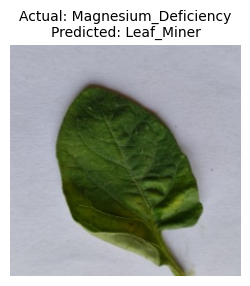

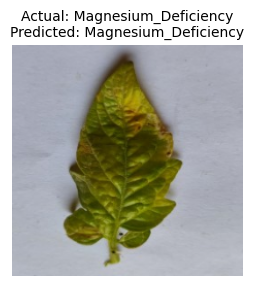

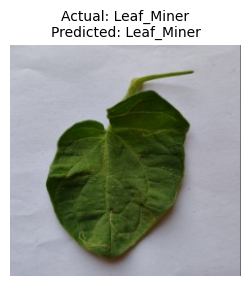

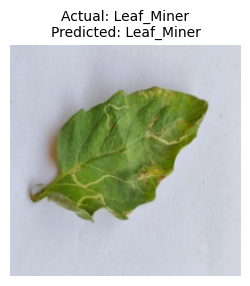

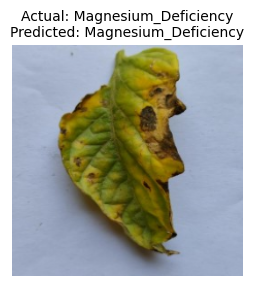

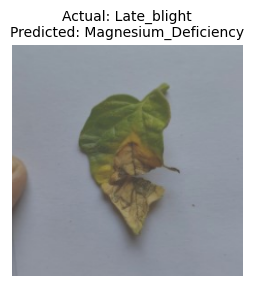

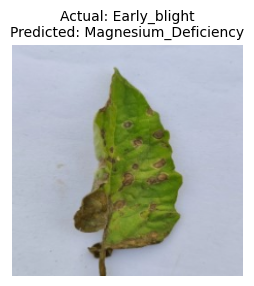

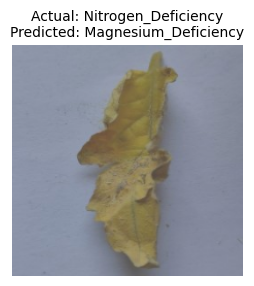

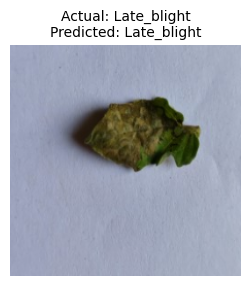

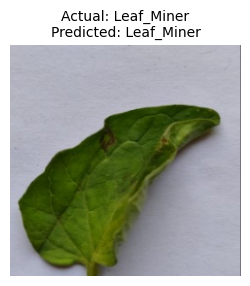

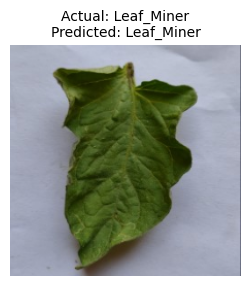

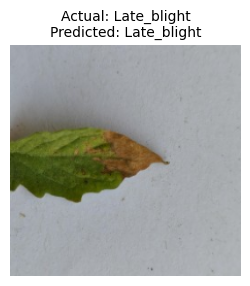

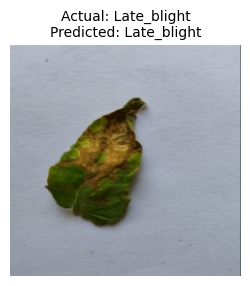

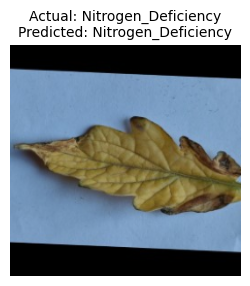

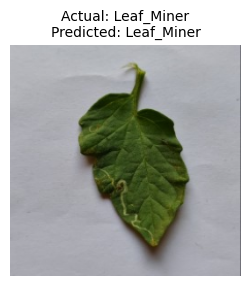

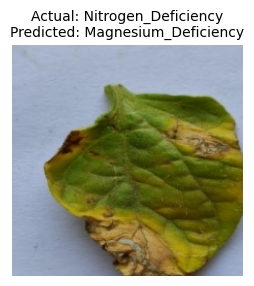

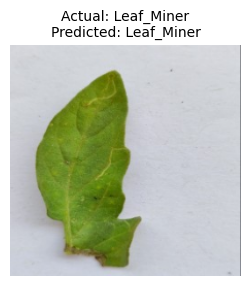

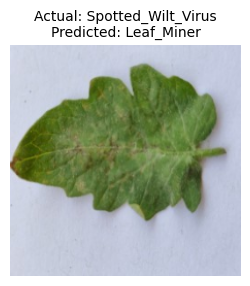

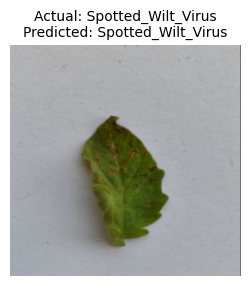

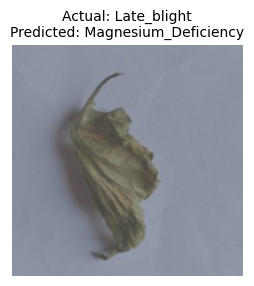

In [38]:
import numpy as np
import random
import matplotlib.pyplot as plt

# Extract features for the test set using MobileNet feature extractor
print("Extracting features from test data...")
#X_test_features = feature_extractor.predict(X_test_features_flat)

# Predict the class labels for the test set using the trained SVM model
y_pred = svm_cnn.predict(X_test_features_flat)

class_labels = ['Early_blight','Healthy','Late_blight','Leaf_Miner',
                 'Magnesium_Deficiency','Nitrogen_Deficiency','Pottassium_Deficiency','Spotted_Wilt_Virus']

# Select 20 random indices from the test set
random_indices = random.sample(range(len(X_test)), 20)

# Loop through the randomly selected indices
for index in random_indices:
    # Select the test image and its corresponding actual label
    test_image = X_test[index]
    actual_label_index = y_test[index]  # Assuming y_test contains the actual labels as indices

    # Get the predicted class label from the SVM prediction
    predicted_class_index = y_pred[index]

    # Get the actual and predicted class labels
    actual_label = class_labels[actual_label_index]
    predicted_label = class_labels[predicted_class_index]

    # Display the image with Matplotlib
    plt.figure(figsize=(3, 3))  # Set figure size

    # If the image is normalized, scale it back to the range [0, 255] for display
    if test_image.max() <= 1.0:
        display_image = test_image * 255  # Rescale to [0, 255]
    else:
        display_image = test_image  # If already in [0, 255], keep it as is

    # Display the image
    plt.imshow(display_image.astype('uint8'))  # Convert to uint8 for correct display
    plt.axis('off')  # Turn off axis
    plt.title(f"Actual: {actual_label}\nPredicted: {predicted_label}", fontsize=10)  # Add title
    plt.show()


In [39]:
from sklearn.metrics import confusion_matrix, roc_curve, auc, accuracy_score, classification_report, RocCurveDisplay, recall_score, f1_score
from sklearn.metrics import precision_score

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
precision_per_class = precision_score(y_test, y_pred, average=None)
f1_per_class = f1_score(y_test, y_pred, average=None)

# Print metrics as percentages rounded to 2 decimal places
print(f"SVM Test Accuracy: {accuracy * 100:.2f}%")
print(f"Precision: {precision * 100:.2f}%")
print(f"Recall: {recall * 100:.2f}%")
print(f"F1 Score: {f1 * 100:.2f}%")

# Print precision and F1 score per class, rounded to 2 decimal places as percentages
print(f"Precision per Class: {[round(p * 100, 2) for p in precision_per_class]}%")
print(f"F1 Score per Class: {[round(f * 100, 2) for f in f1_per_class]}%")

SVM Test Accuracy: 50.33%
Precision: 46.43%
Recall: 50.33%
F1 Score: 46.18%
Precision per Class: [26.67, 0.0, 56.79, 52.47, 48.15, 72.22, 0.0, 40.43]%
F1 Score per Class: [12.31, 0.0, 53.18, 63.91, 56.52, 47.27, 0.0, 38.0]%


C:\Users\SwarnaliMollick\anaconda3\envs\tfgpu\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\SwarnaliMollick\anaconda3\envs\tfgpu\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
